# COVID-19 Global Forecasting

This notebook will focus on forecasting the number of new cases and deaths caused by the COVID-19 virus during the month of April 2020.

The link to the competition description and data sources is the following:
https://www.kaggle.com/c/covid19-global-forecasting-week-3/data

## Data

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.ticker as ticker
import re
from collections import Counter
style.use('fivethirtyeight')
palette = "ch:-.2,2.5,dark=.3_r"

# Interactive shell settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [124]:
# Reading provided data
train = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/train.csv', 
                   date_parser='Date' )
test = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/test.csv',
                   date_parser='Date')
submission = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/submission.csv')

# Making column names easier to work with
orginal_columns = train.columns
train.columns = [c.lower() for c in train.columns]
train.columns

Index(['id', 'province_state', 'country_region', 'date', 'confirmedcases',
       'fatalities'],
      dtype='object')

In [125]:
# Looking at the datasets
train.head()
test.head()
submission.head()

,id,province_state,country_region,date,confirmedcases,fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


## Exploratory Data Analysis

In [126]:
# Train data description
train[['confirmedcases', 'fatalities']].describe()
train.info()
print('\n')

# Main facts
max_date = train.date.max()
total_countries = train.country_region.nunique()
total_cases = train[train['date']==max_date].confirmedcases.sum()
total_deaths =train[train['date']==max_date].fatalities.sum()

print('Max Date:', max_date)
print('Number of countries:', total_countries) 
print('Total Cases:', total_cases)
print('Total Deaths:', total_deaths)

,confirmedcases,fatalities
count,25353.000000,25353.000000
mean,1003.824518,50.392853
std,7542.589521,592.843013
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,93.000000,1.000000
max,181026.000000,19468.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25353 entries, 0 to 25352
Data columns (total 6 columns):
id                25353 non-null int64
province_state    10773 non-null object
country_region    25353 non-null object
date              25353 non-null object
confirmedcases    25353 non-null float64
fatalities        25353 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


Max Date: 2020-04-11
Number of countries: 184
Total Cases: 1771337.0
Total Deaths: 108497.0


In [127]:
# Countries with the most cases and fatalities ordered by date and cases 
top = (train[train['date'] == max_date]
       .groupby(['date','country_region'])[['confirmedcases','fatalities']]
       .sum()
       .sort_values(by=['confirmedcases','fatalities'], ascending=False))

top.head(25)
top.tail(25)

confirmedcases  fatalities
date       country_region                            
2020-04-11 US                    526233.0     20458.0
           Spain                 163027.0     16606.0
           Italy                 152271.0     19468.0
           France                130727.0     13851.0
           Germany               124908.0      2736.0
           China                  83014.0      3343.0
           United Kingdom         79874.0      9892.0
           Iran                   70029.0      4357.0
           Turkey                 52167.0      1101.0
           Belgium                28018.0      3346.0
           Switzerland            25107.0      1036.0
           Netherlands            24571.0      2653.0
           Canada                 23303.0       653.0
           Brazil                 20727.0      1124.0
           Portugal               15987.0       470.0
           Austria                13806.0       337.0
           Russia                 13584.0       106.0
           Israel                 10743.0       101.0
           Korea, South           10480.0       211.0
           Sweden                 10151.0       887.0
           Ireland                 8928.0       320.0
           India                   8446.0       288.0
           Ecuador                 7257.0       315.0
           Chile                   6927.0        73.0
           Peru                    6848.0       181.0

confirmedcases  fatalities
date       country_region                                              
2020-04-11 Belize                                      13.0         2.0
           Botswana                                    13.0         1.0
           Malawi                                      12.0         2.0
           Eswatini                                    12.0         0.0
           Saint Kitts and Nevis                       12.0         0.0
           Saint Vincent and the Grenadines            12.0         0.0
           Chad                                        11.0         0.0
           Seychelles                                  11.0         0.0
           Suriname                                    10.0         1.0
           MS Zaandam                                   9.0         2.0
           Gambia                                       9.0         1.0
           Nepal                                        9.0         0.0
           Cabo Verde                                   8.0         1.0
           Nicaragua                                    8.0         1.0
           Central African Republic                     8.0         0.0
           Holy See                                     8.0         0.0
           Sierra Leone                                 8.0         0.0
           Mauritania                                   7.0         1.0
           Bhutan                                       5.0         0.0
           Burundi                                      5.0         0.0
           Sao Tome and Principe                        4.0         0.0
           South Sudan                                  4.0         0.0
           Western Sahara                               4.0         0.0
           Papua New Guinea                             2.0         0.0
           Timor-Leste                                  2.0         0.0

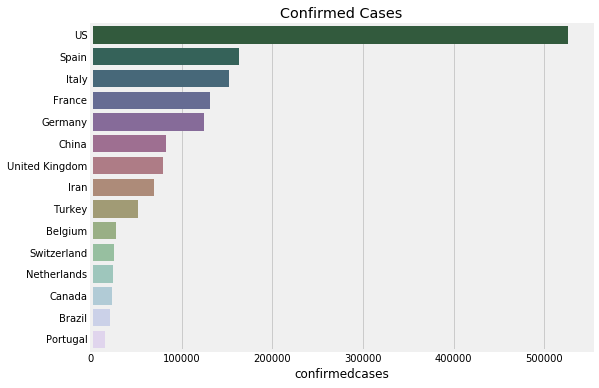

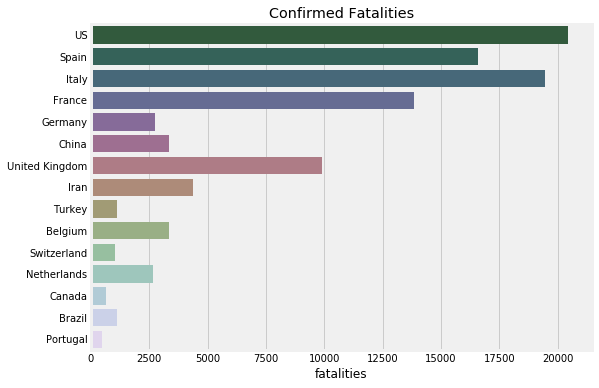

In [89]:
# Bar graph for most affected countries by cases and fatalities
fig,axes = plt.subplots(figsize=(8,6))
sns.barplot(y =top.index.get_level_values(1)[0:15], x=top['confirmedcases'][0:15], palette=palette)
plt.title('Confirmed Cases')
plt.ylabel('')
plt.show();

fig,axes = plt.subplots(figsize=(8,6))
sns.barplot(y =top.index.get_level_values(1)[0:15], x=top['fatalities'][0:15],palette=palette)
plt.title('Confirmed Fatalities')
plt.ylabel('')
plt.show();

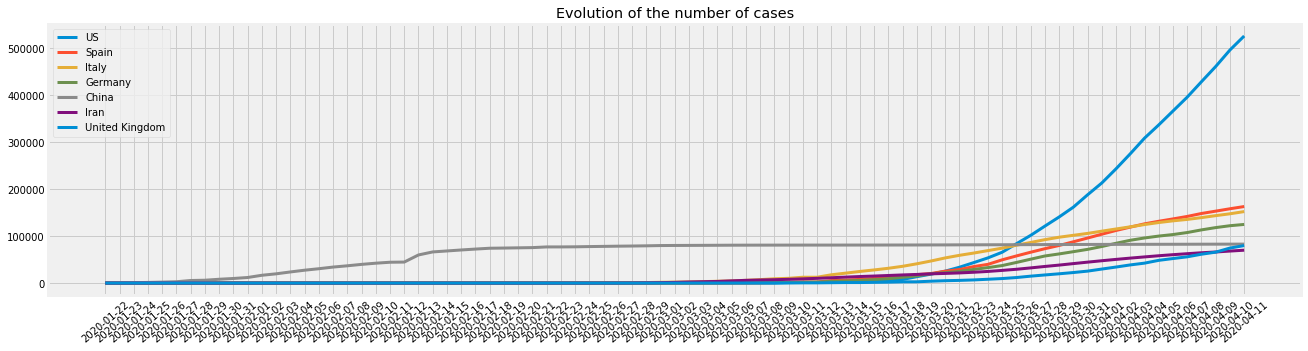

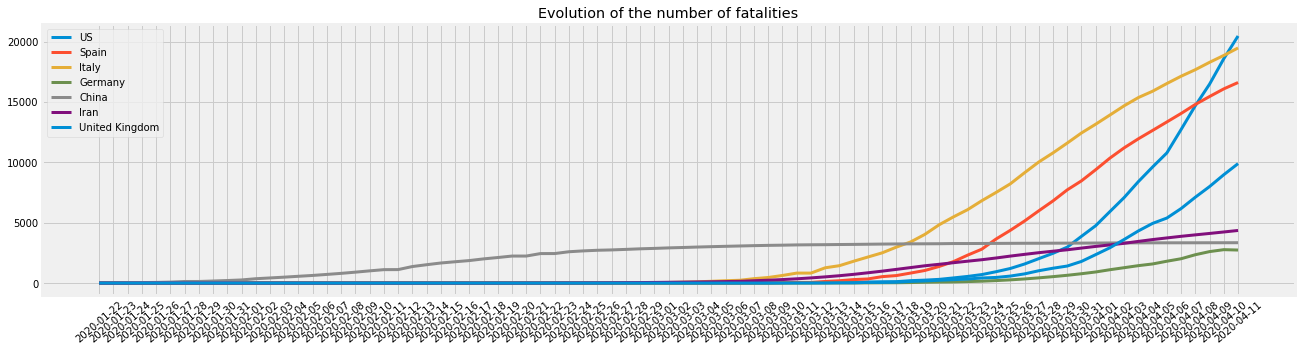

In [123]:
# Creating graphs with case count and fatality trends by country
def Country_cases(df, ConfirmedCases,*argv):
    fig, axes=plt.subplots(figsize=(20,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['country_region']==a)]
        plt.plot(country['date'],country['confirmedcases'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        axes.set(title='Evolution of the number of cases' )

def Country_fatalities(df, Fatalities,*argv):
    fig, axes=plt.subplots(figsize=(20,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['country_region']==a)]
        plt.plot(country['date'],country['fatalities'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        axes.set(title='Evolution of the number of fatalities' )
                
train_sum=train.groupby(['date','country_region']).agg('sum').reset_index()

Country_cases(train_sum,'confirmedcases','US','Spain','Italy','Germany', 'China','Iran', 'United Kingdom')
Country_fatalities(train_sum,'fatalities','US','Spain','Italy','Germany', 'China','Iran', 'United Kingdom')       